In [56]:
import pandas as pd
import numpy as np
import configparser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns
from clickhouse_driver import Client

In [57]:
config = configparser.ConfigParser()
config.read('config.ini')

server = config.get('clickhouse', 'server')
user = config.get('clickhouse', 'user')
password = config.get('clickhouse', 'password')

client_CH = Client(server, user=user, password=password, settings={"use_numpy": True})
# Test connection
client_CH.execute('SELECT * FROM system.one LIMIT 10')

[array([0], dtype=uint8)]

In [58]:
# The following code retrieves data from a table named 'store_sales_predictions' in a SQL database using a client connection.
sql = "SELECT * FROM picker_tables.store_sales_predictions"

# The query_dataframe method of the client_CH object is used to execute the SQL command and retrieve the resulting data as a Pandas dataframe.
df_pred = client_CH.query_dataframe(sql)
df_pred.head(2)


,store_nbr,family,last_value,pred1_t,pred1,pred2_t,pred2,pred3_t,pred3,pred4_t,pred4,pred5_t,pred5
0,30,"LIQUOR,WINE,BEER",36.0,48.522988,48.522988,56.655686,56.655686,33.598757,33.598757,32.952462,32.952462,29.70501,29.70501
1,35,BABY CARE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df_train = pd.read_csv('./data/train.csv')
print(df_train.shape)
df_train.head(2)

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0


In [60]:
# Take a part of the training data for visualization and analysis
df = df_train[df_train['date'] >= '2017-07-01']

# Group by 'store_nbr' and 'family', and calculate the percentage of zeroes in 'sales'
grouped = df.groupby(['store_nbr', 'family']).agg({'sales': [('zero_count', lambda x: (x == 0).sum()), ('total_count', 'count')]})
grouped.columns = grouped.columns.droplevel(0)
grouped['zero_percentage'] = (grouped['zero_count'] / grouped['total_count']) * 100

# Filter the groups with less than or equal to 10% zeroes
filtered_groups = grouped[grouped['zero_percentage'] <= 10].reset_index()

# Merge the filtered groups back to the original 2016 DataFrame
df = pd.merge(df, filtered_groups[['store_nbr', 'family']], on=['store_nbr', 'family'])

# Remove families that are not have periodicity
df = df[(df['family'] != 'HOME AND KITCHEN I') & (df['family'] != 'LAWN AND GARDEN') & (df['family'] != 'SCHOOL AND OFFICE SUPPLIES') & (df['family'] != 'HOME AND KITCHEN II')]

print('Resulting shape of dataframe:' , df[['store_nbr', 'family']].drop_duplicates().shape)

Resulting shape of dataframe: (1231, 2)


In [61]:
# The following code defines a function named 'calculate_mse' that takes in two parameters, y_true and y_pred.
def calculate_mse(y_true, y_pred):
    n = len(y_true)
    mse = (1/n) * np.sum((y_true - y_pred)**2)
    return mse

In [62]:
# Split the dataframe into train and test
df_train = df.groupby(['store_nbr', 'family']).apply(lambda x: x.iloc[:-5]).reset_index(drop=True)
df_test = df.groupby(['store_nbr', 'family']).apply(lambda x: x.iloc[-5:]).reset_index(drop=True)

In [63]:
# Calculate baseline predictors
def baseline_predictors(group):
    last_value = group.iloc[-1]['sales']
    mean_30_days = group.tail(30)['sales'].mean()
    mean_7_days = group.tail(7)['sales'].mean()
    return pd.Series({'last_value': last_value, 'mean_30_days': mean_30_days, 'mean_7_days': mean_7_days})

baselines = df_train.groupby(['store_nbr', 'family']).apply(baseline_predictors).reset_index()

In [64]:
# Calculate the MSE for each baseline predictor and the given predictors
mse_list = []
for _, row in baselines.iterrows():
    store_nbr, family, last_value, mean_30_days, mean_7_days = row
    test_group = df_test[(df_test['store_nbr'] == store_nbr) & (df_test['family'] == family)]
    preds_group = df_pred[(df_pred['store_nbr'] == store_nbr) & (df_pred['family'] == family)].iloc[0]
    mse_last_value = calculate_mse(test_group['sales'], [last_value] * 5)
    mse_mean_30_days = calculate_mse(test_group['sales'], [mean_30_days] * 5)
    mse_mean_7_days = calculate_mse(test_group['sales'], [mean_7_days] * 5)
    predictions = [preds_group[f'pred{i}'] for i in range(1, 6)]
    mse_preds = calculate_mse(test_group['sales'], predictions)
    mse_list.append((store_nbr, family, mse_last_value, mse_mean_30_days, mse_mean_7_days, mse_preds))

# Store the MSEs in a separate dataframe
mse_df = pd.DataFrame(mse_list, columns=['store_nbr', 'family', 'mse_last_value', 'mse_mean_30_days', 'mse_mean_7_days', 'mse_pred'])

# Filter the columns with 'mse' in the name
mse_columns = [col for col in mse_df.columns if 'mse' in col]
print(mse_df[mse_columns].sum())

mse_last_value      2.402029e+08
mse_mean_30_days    1.271595e+08
mse_mean_7_days     1.025831e+08
mse_pred            1.018569e+08
dtype: float64


In [65]:
top5_mse_pred = mse_df.nlargest(5, 'mse_pred')
# Print the 'store_nbr' and 'family' columns of the top 5 rows
print(top5_mse_pred[['store_nbr', 'family', 'mse_pred']])

      store_nbr     family      mse_pred
626          28  GROCERY I  1.354681e+07
881          40  GROCERY I  4.348128e+06
1213         54  BEVERAGES  2.819726e+06
723          33  BEVERAGES  2.605172e+06
857          39  GROCERY I  2.327557e+06


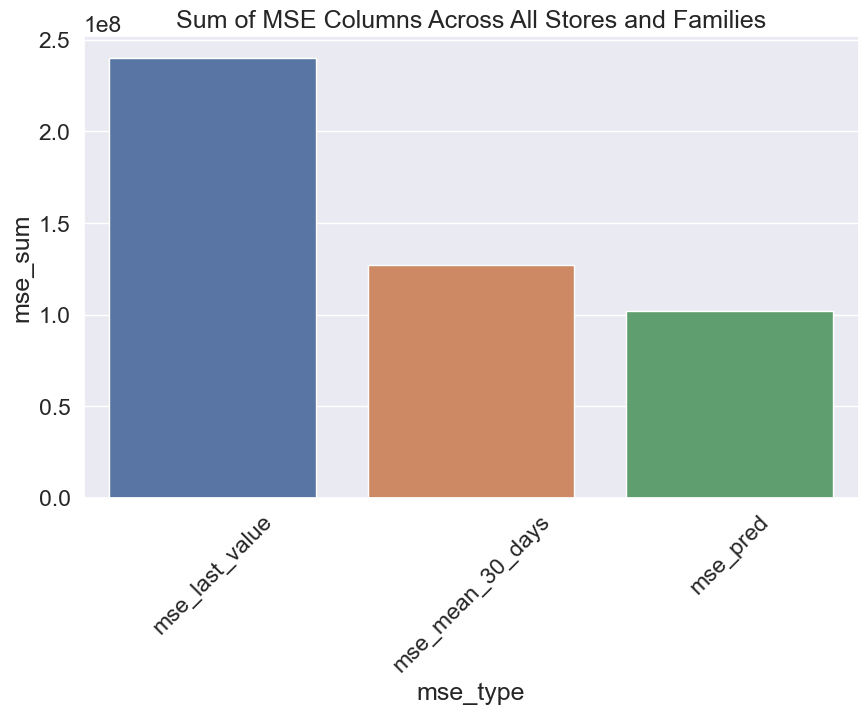

In [66]:
mse_sums = mse_df[['mse_last_value', 'mse_mean_30_days', 'mse_pred']].sum()

# Convert data into long format
mse_sums_df = mse_sums.reset_index().rename(columns={'index': 'mse_type', 0: 'mse_sum'})

# Set the font scale
sns.set(font_scale=1.5)

# Create the barplot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='mse_type', y='mse_sum', data=mse_sums_df)
plt.title('Sum of MSE Columns Across All Stores and Families')
plt.xticks(rotation=45)
plt.show()

In [67]:
stores_for_plot = [4, 7]
families_for_plot = ['LIQUOR,WINE,BEER', 'GROCERY I']

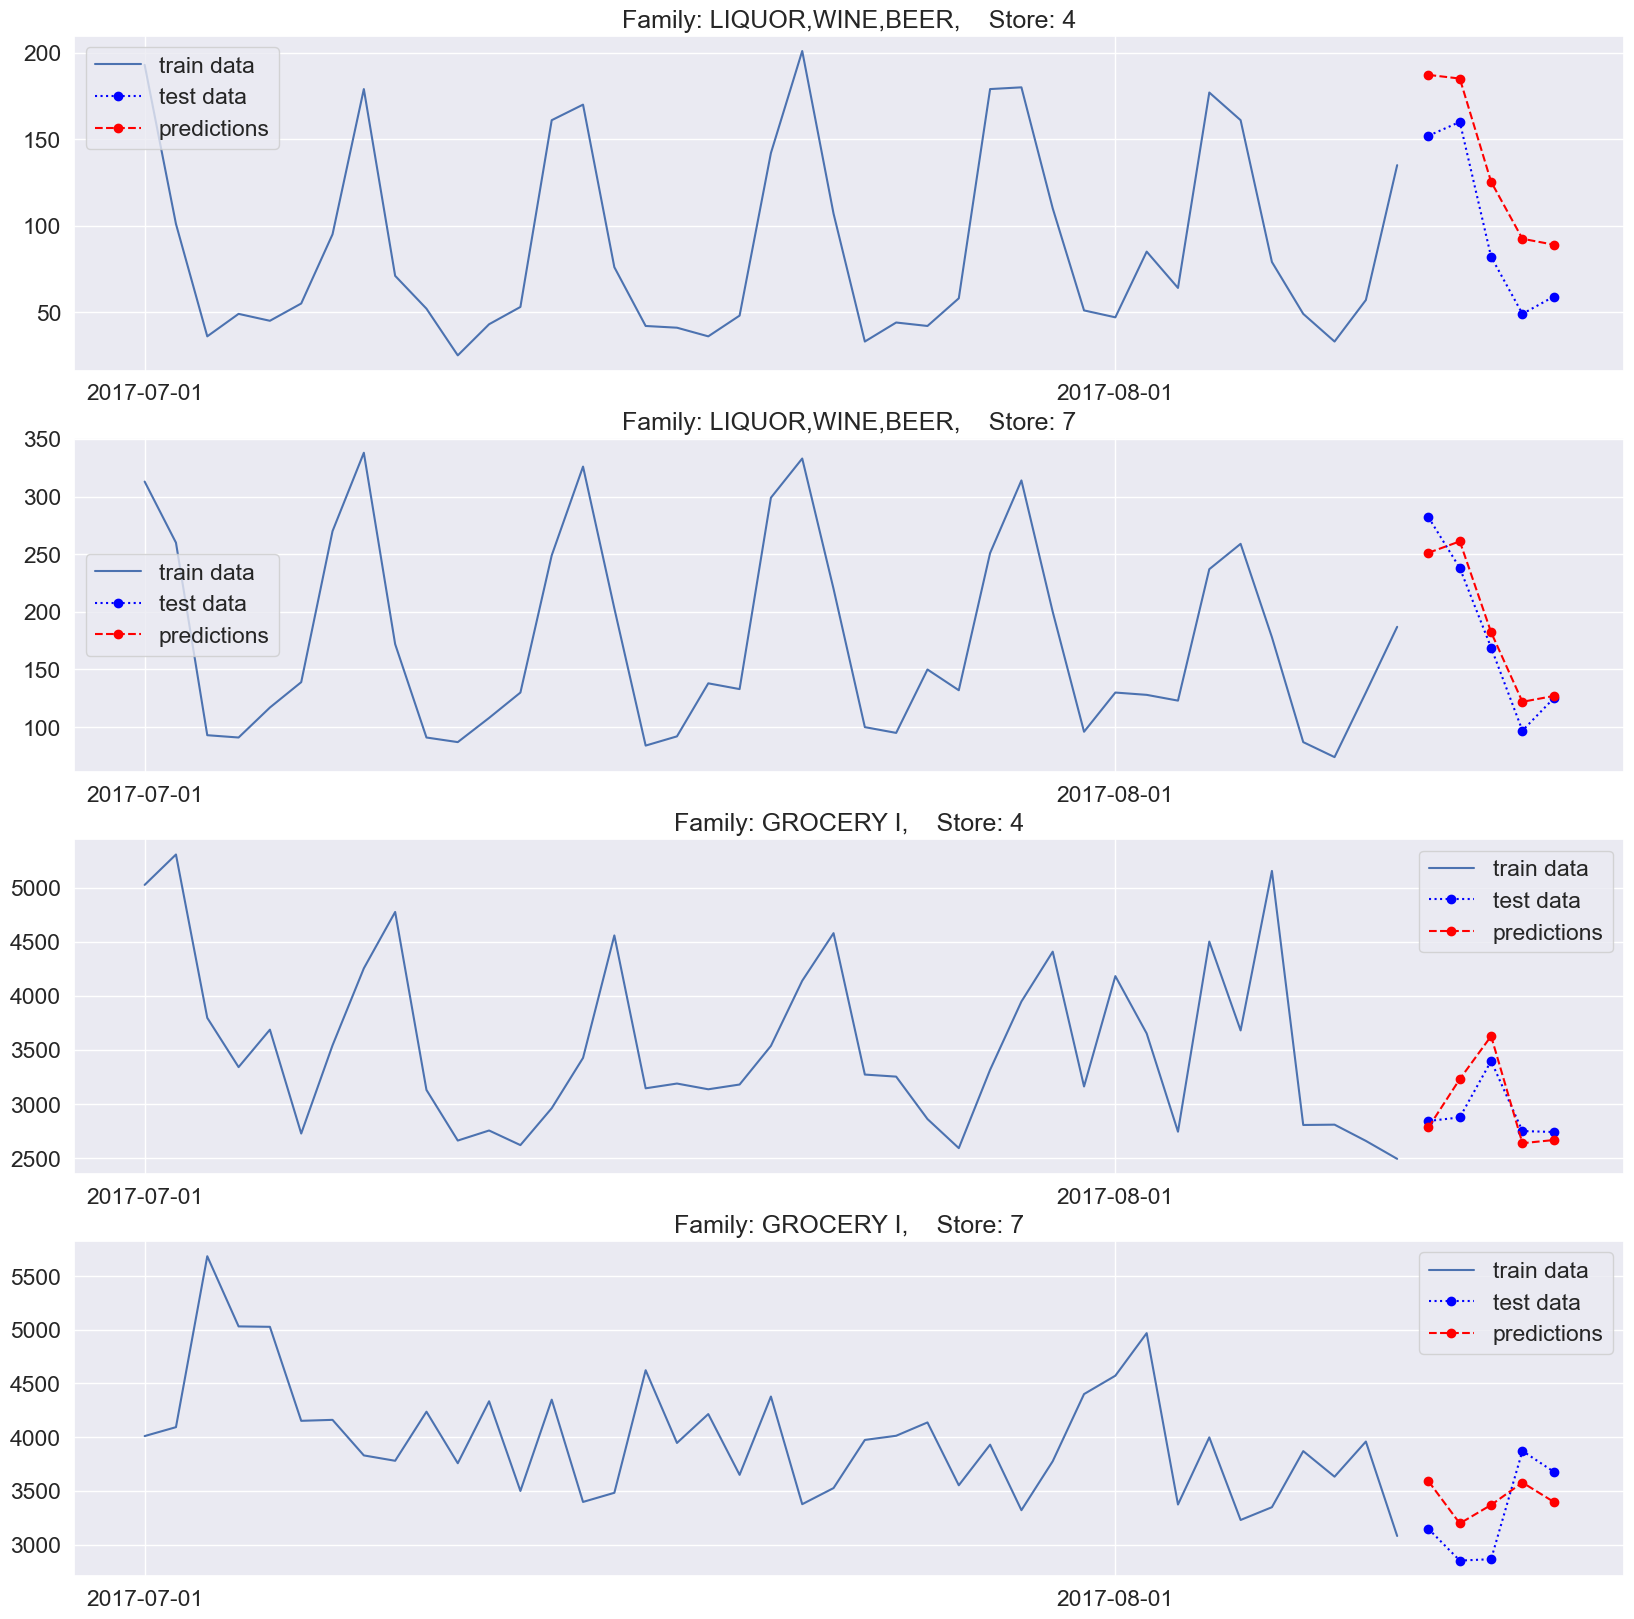

In [69]:
# Create a subplot for each combination of family and store
fig, axs = plt.subplots(len(stores_for_plot)*len(families_for_plot), 1, figsize=(20, 20))

for i, family in enumerate(families_for_plot):
    for j, store in enumerate(stores_for_plot):
        data = df[(df['store_nbr'] == store) & (df['family'] == family)].sort_values('date')
        pred_data = df_pred[(df_pred['store_nbr'] == store) & (df_pred['family'] == family)]
        train_data = data.iloc[:-5]
        test_data = data.iloc[-5:]
        if len(test_data) > 0:
            axs[i*len(stores_for_plot)+j].plot(train_data['date'], train_data['sales'], label=f'train data')
            axs[i*len(stores_for_plot)+j].plot(test_data['date'], test_data['sales'], linestyle=':', marker='o', label = f'test data', color='blue')
            pred_dates = test_data['date']
            pred_values = pred_data[['pred1', 'pred2', 'pred3', 'pred4', 'pred5']].values[0].astype(float)
            axs[i*len(stores_for_plot)+j].plot(pred_dates, pred_values, marker='o', linestyle='--', label = f'predictions', color='red')
            axs[i*len(stores_for_plot)+j].set_title('Family: {},    Store: {}'.format(family, store))
            axs[i*len(stores_for_plot)+j].xaxis.set_major_locator(mdates.MonthLocator())
            axs[i*len(stores_for_plot)+j].legend()

# Display the plot
plt.show()